To begin copy this notebook to your own drive:

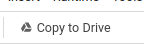


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Upload the downloaded notebook (.ipynb file) to your repository**.

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous two sections we dealt with word-level language models. But looking again at section 2, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 2 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 3.a
Can you think of an advantage a character-based language model could have over a word-based language model? And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model? (Add your answer to the final submission pdf).

In character-based language models, the vocabulary in of fixed size in contrast to word-based language models however the notion of context is not well-defined between characters because there is no semantic relations between individual characters. In word-based language models, the vocabulary size is not consistent between different texts. Generation in word-based language models is easier because the vocabulary is already composed of real words in contrast to generation in character-based models there is a risk that gibberish words will be generated.

### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.0 MB/s eta 0:00:00


In [2]:
import string
import random
import re
import requests
import unidecode
url = "https://github.com/tau-nlp-course/NLP_HW2/raw/main/data/shakespeare.txt"


all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(requests.get(url).content.decode())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [3]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

 this writing here, and thou shalt know
The treason that my haste forbids me show.

DUKE OF AUMERLE:
Remember, as thou read'st, thy promise pass'd:
I do repent me; read not my name there
My heart is not confederate with my hand.

DUKE OF YORK:
It was, villain, ere thy hand did set it down.
I tore it from the traitor's bosom, king;
Fear, and not love, begets his penitence:
Forget to pity him, lest t


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\] 

### Question 3.b
Complete the implementation of the `forward` method of our model.

In [42]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        x = torch.unsqueeze(self.embedding(input_), 0)
        if len(x.shape) < 3:
          x = torch.unsqueeze(x, 0)
        output, hidden = self.gru(x, hidden)
        output = torch.squeeze(self.output_layer(output), 0)
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [89]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Now we can assemble a pair of input and target tensors (i.e. a single training example) for training, from a random chunk. The input will be all characters *except the last*, and the target will be all characters *except the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [14]:
def random_training_set():    
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [15]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [22]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [17]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [18]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [43]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  epochs: {epoch} ({epoch / n_epochs * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 28s  ;  epochs: 100 (5.0%)  ;  loss: 2.181]
Whlout thare him thid mas the.

ARD:
Tis nors, Lot gren wim ther wlot replaes.

BINEIS:
So diornd, of beris on the mere freron ham beanon, roumse. Nord yot hour e ble, my ale min',
Gor lont ot of, Pen e 

[time elapsed: 0m 59s  ;  epochs: 200 (10.0%)  ;  loss: 2.12]
Whow shothe to is what and thou, canione hod sit woha ding; wih wee your not ming thou hour sight-you with of his my love heme his silld re suor fesvere ith I'l lenther thave dout ing thou hom stat the  

[time elapsed: 1m 33s  ;  epochs: 300 (15.0%)  ;  loss: 2.04]
Why noth't suting beangain
I the hould weing, brane the thiss peare
The sould the pel.

FiLA:
What but with to this it thee be the he preisty thou me he peplear's brount the me of beverst
That be gof bu 

[time elapsed: 2m 5s  ;  epochs: 400 (20.0%)  ;  loss: 2.266]
Whable a nawhisher; the duke thale, servere:
What who, make this I and then you hard lise I'll conting,
That so talence thou we un there 

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning (Add your plot to the final submission pdf).

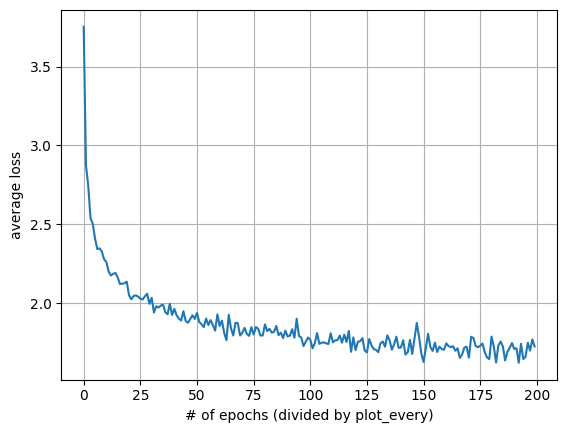

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of epochs (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

# 4.b Perplexity

In [119]:
import string
import random
import re
import requests
import unidecode

def perplexity(filepath):
  text = ""
  with open(filepath) as f:
    text = unidecode.unidecode(f.read())

  hidden = model.init_hidden()
  prime_input = chars_to_tensor(text)
  inp = prime_input[-1]

  sum_log_probs = 0
  for p in range(len(text) - 1):
      output, hidden = model(inp, hidden)
      output_dist =  F.softmax(output / 0.8, dim=-1)      
      char_prob = output_dist[:, all_characters.index(text[p])]
      sum_log_probs += torch.log(char_prob)
      inp = prime_input[p]

  return torch.exp((-1.0/len(text))*sum_log_probs).item()


In [120]:
print(perplexity("/content/shakespeare_for_perplexity.txt"))

7.159401893615723


In [121]:
print(perplexity("/content/wikipedia_for_perplexity.txt"))

20.321489334106445
